In [1]:
import warnings
warnings.filterwarnings('ignore')

!pip install -q seaborn
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
BATCH_SIZE = 64
n_classes = 6

# Resnet50 base model
conv_base = ResNet50(input_shape= (224,224,3), weights='imagenet', include_top=False)

# Freeze all layers except the last two
for layer in conv_base.layers:
    layer.trainable = False

# Top model
top_model = Flatten()(conv_base.output)
output_layer = Dense(n_classes, activation='softmax')(top_model)

# Final Model
model = Model(inputs=conv_base.input, outputs=output_layer)

94765736/94765736 [==============================] - 1s 0us/step


In [2]:
def plot_random_images(generator, num_images=20):
    # Get a batch of data from the generator
    images, labels = next(generator)

    # Get random indices for selecting images
    random_indices = np.random.choice(images.shape[0], num_images, replace=False)

    # Plot the selected images
    fig, axs = plt.subplots(4, 5, figsize=(15, 12))
    fig.suptitle('Random 20 Images from the Generator', fontsize=16)

    for i, ax in enumerate(axs.flatten()):
        index = random_indices[i]
        image = images[index]
        label = labels[index]

        # Display the image
        ax.imshow(image)
        ax.set_title(f'Class: {np.argmax(label)}')
        ax.axis('off')

    plt.show()

In [3]:
data_path = '/kaggle/input/garbage-classification-6-classes-775class'

Found 4650 images belonging to 6 classes.


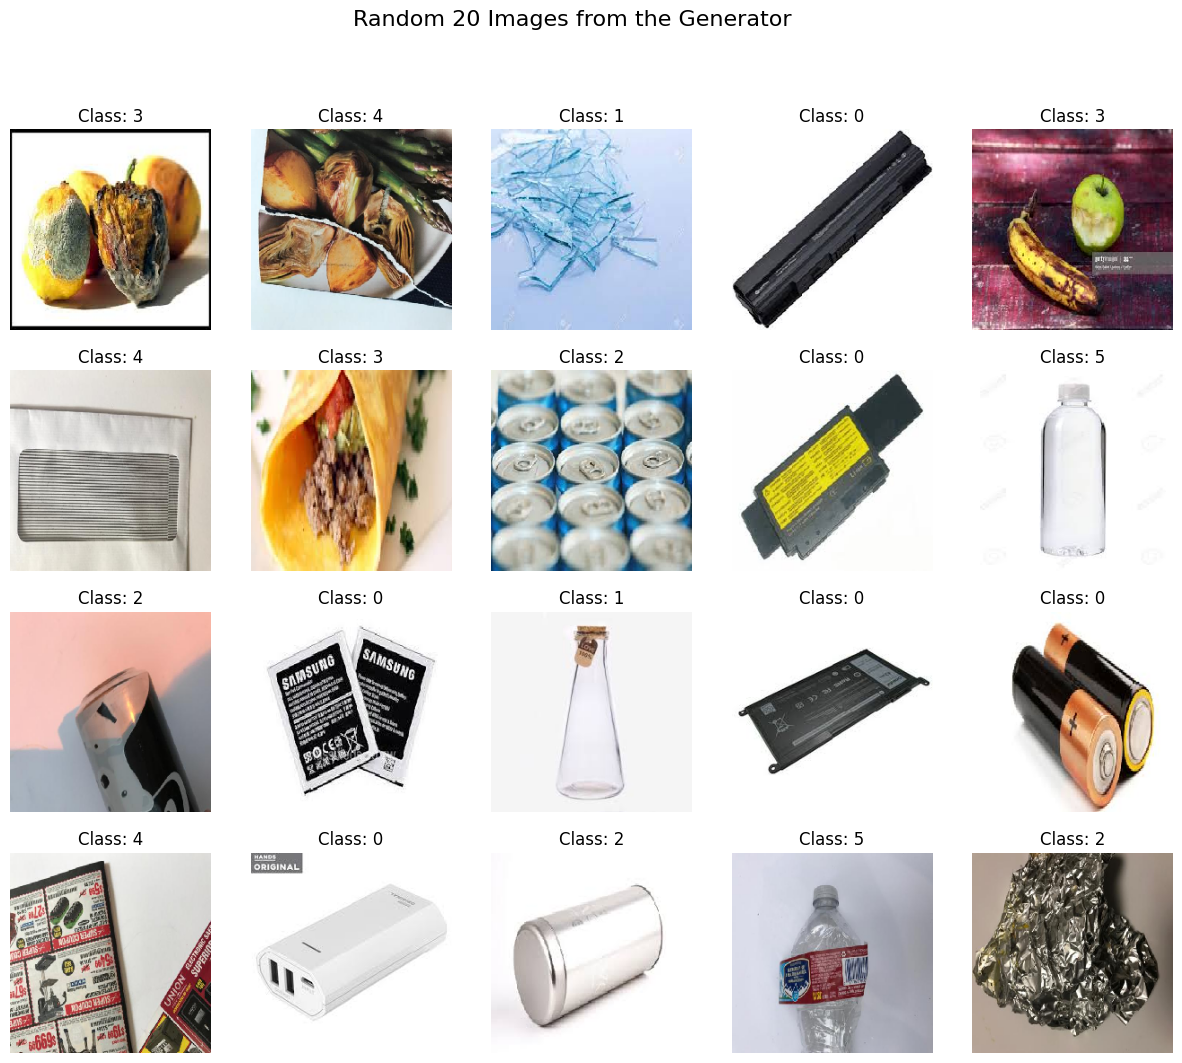

In [4]:
original_data = ImageDataGenerator(rescale=1./255).flow_from_directory(data_path, target_size = (224, 224), batch_size = BATCH_SIZE, class_mode="categorical")
plot_random_images(original_data)

Found 4650 images belonging to 6 classes.


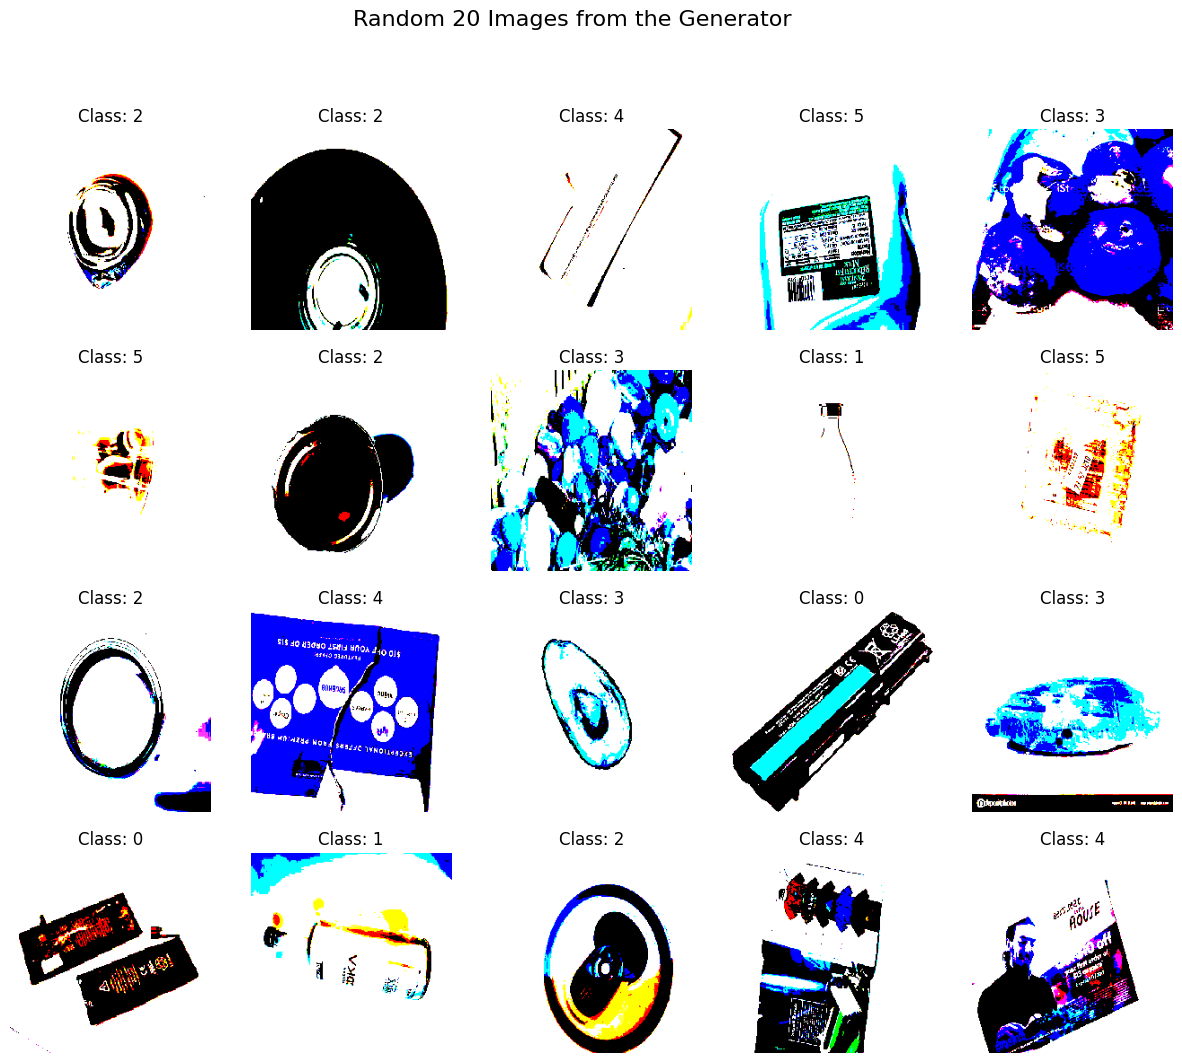

In [5]:
gen_train = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing
full_data = gen_train.flow_from_directory(data_path, target_size = (224, 224), batch_size = BATCH_SIZE, class_mode="categorical")
plot_random_images(full_data)

In [6]:
# Extract filenames and labels from the DirectoryIterator
filenames = full_data.filenames
labels = full_data.labels
class_mapping = {value: str(key) for key, value in full_data.class_indices.items()}
labels = [class_mapping[label] for label in labels]

filenames[:5], labels[:5]

(['battery/battery1.jpg',
  'battery/battery10.jpg',
  'battery/battery100.jpg',
  'battery/battery101.jpg',
  'battery/battery102.jpg'],
 ['battery', 'battery', 'battery', 'battery', 'battery'])

In [7]:
# Split the data into training and testing sets
train_filenames, test_filenames, train_labels, test_labels = train_test_split(
    filenames, labels, test_size=0.1, random_state=42)

# Create DataFrames for training and testing
train_df = pd.DataFrame({'filename': train_filenames, 'class': train_labels})
test_df = pd.DataFrame({'filename': test_filenames, 'class': test_labels})

# Create separate generators for training and testing using flow_from_dataframe
train_data = gen_train.flow_from_dataframe(train_df, directory=data_path, target_size=(224, 224),
                                           batch_size=BATCH_SIZE, class_mode="categorical",
                                           shuffle=True, seed=42)

test_data = gen_train.flow_from_dataframe(test_df, directory=data_path, target_size=(224, 224),
                                          batch_size=BATCH_SIZE, class_mode="categorical",
                                          shuffle=False)

Found 4185 validated image filenames belonging to 6 classes.
Found 465 validated image filenames belonging to 6 classes.


In [8]:
num_epochs = 200
opt = Adam(learning_rate=0.0001)
model.compile(
    optimizer=opt, 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
checkpoint = ModelCheckpoint(
    filepath='model.resnet50.h5',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)
early = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [10]:
n_steps = train_data.samples // BATCH_SIZE
n_val_steps = test_data.samples // BATCH_SIZE
n_steps, n_val_steps

(65, 7)

In [11]:
result = model.fit(
    train_data, 
    epochs=num_epochs, 
    steps_per_epoch=n_steps,
    validation_data=test_data, 
    validation_steps=n_val_steps,
    callbacks=[early, checkpoint, reduce_lr]
)

Epoch 1/200
65/65 [==============================] - ETA: 0s - loss: 0.5790 - accuracy: 0.8374
Epoch 1: val_loss improved from inf to 0.29373, saving model to model.resnet50.h5
65/65 [==============================] - 41s 498ms/step - loss: 0.5790 - accuracy: 0.8374 - val_loss: 0.2937 - val_accuracy: 0.9174 - lr: 1.0000e-04
Epoch 2/200
65/65 [==============================] - ETA: 0s - loss: 0.0522 - accuracy: 0.9823
Epoch 2: val_loss improved from 0.29373 to 0.23138, saving model to model.resnet50.h5
65/65 [==============================] - 18s 281ms/step - loss: 0.0522 - accuracy: 0.9823 - val_loss: 0.2314 - val_accuracy: 0.9263 - lr: 1.0000e-04
Epoch 3/200
65/65 [==============================] - ETA: 0s - loss: 0.0143 - accuracy: 0.9971
Epoch 3: val_loss improved from 0.23138 to 0.22395, saving model to model.resnet50.h5
65/65 [==============================] - 20s 301ms/step - loss: 0.0143 - accuracy: 0.9971 - val_loss: 0.2239 - val_accuracy: 0.9353 - lr: 1.0000e-04
Epoch 4/200
65

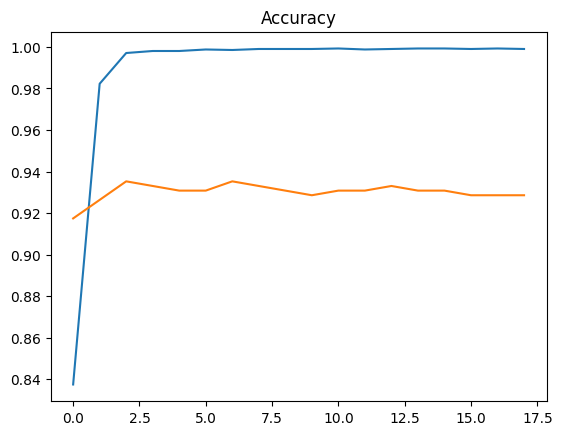

In [12]:
plt.title("Accuracy")
plt.plot(result.history["accuracy"])
plt.plot(result.history["val_accuracy"])
plt.show()

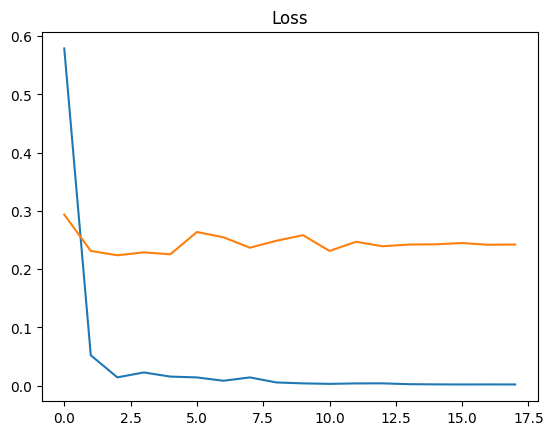

In [13]:
plt.title("Loss")
plt.plot(result.history["loss"])
plt.plot(result.history["val_loss"])
plt.show()

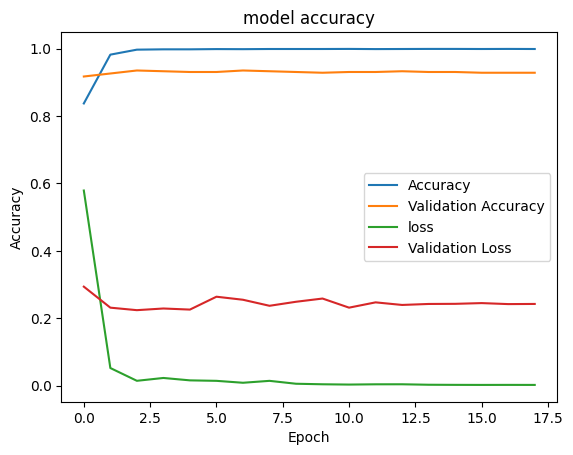

In [14]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [15]:
model.save("model_resnet50.h5")

8/8 [==============================] - 4s 362ms/step


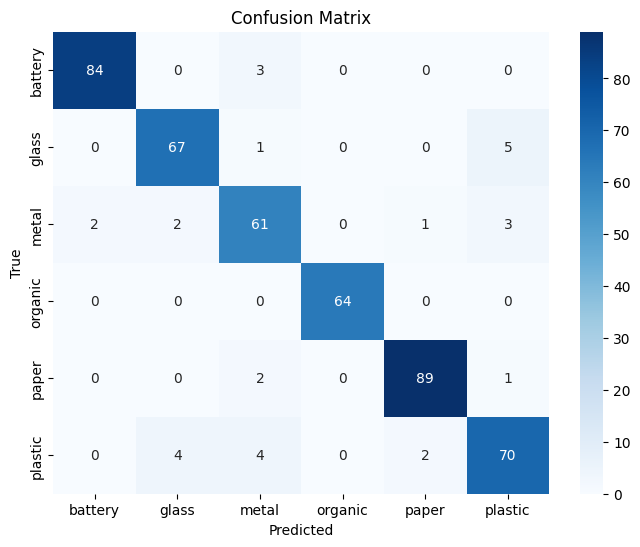

              precision    recall  f1-score   support

     battery       0.98      0.97      0.97        87
       glass       0.92      0.92      0.92        73
       metal       0.86      0.88      0.87        69
     organic       1.00      1.00      1.00        64
       paper       0.97      0.97      0.97        92
     plastic       0.89      0.88      0.88        80

    accuracy                           0.94       465
   macro avg       0.93      0.93      0.93       465
weighted avg       0.94      0.94      0.94       465



In [16]:
predictions = model.predict(test_data)

# Get the predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the true class labels
true_labels = test_data.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_data.class_indices.keys(),
            yticklabels=test_data.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
class_names = list(test_data.class_indices.keys())
print(classification_report(true_labels, predicted_labels, target_names=class_names))

In [17]:
output_class = ["battery", "glass", "metal","organic", "paper", "plastic"]

def preprocessing_input(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img) # VGG16 preprocess_input
    return img

def plot_images(original, preprocessed):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(original)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # Remove the batch dimension for display
    preprocessed = np.squeeze(preprocessed, axis=0)

    axs[1].imshow(preprocessed)
    axs[1].set_title('Preprocessed Image')
    axs[1].axis('off')

    plt.show()

def predict_user(img_path):
    img = preprocessing_input(img_path)
    plot_images(Image.open(img_path), img)
    predicted_array = model.predict(img)
    predicted_value = output_class[np.argmax(predicted_array)]
    predicted_accuracy = round(np.max(predicted_array) * 100, 2)
    print("Your waste material is", predicted_value, "with", predicted_accuracy, "% accuracy.")

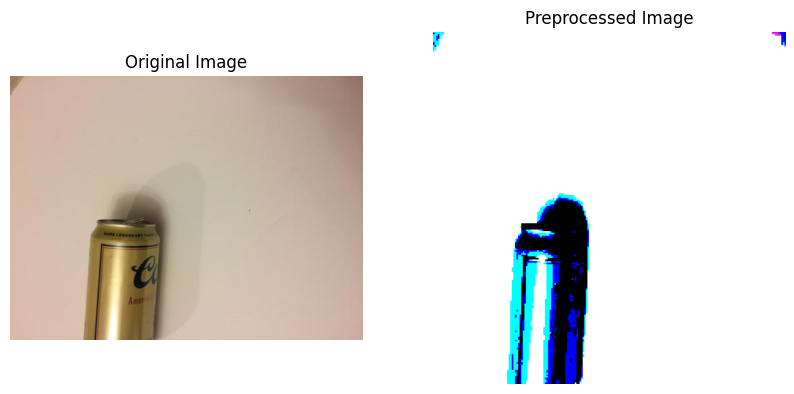

1/1 [==============================] - 1s 1s/step
Your waste material is metal with 99.84 % accuracy.


In [18]:
predict_user('/kaggle/input/test-data/metal117.jpg')

In [19]:
result = model.fit(
    train_data, 
    epochs=num_epochs, 
    steps_per_epoch=n_steps,
    validation_data=test_data, 
    validation_steps=n_val_steps,
    callbacks=[early, checkpoint, reduce_lr]
)

Epoch 1/200
65/65 [==============================] - ETA: 0s - loss: 0.0126 - accuracy: 0.9988
Epoch 1: val_loss did not improve from 0.22395
65/65 [==============================] - 19s 292ms/step - loss: 0.0126 - accuracy: 0.9988 - val_loss: 0.2240 - val_accuracy: 0.9308 - lr: 1.0000e-06
Epoch 2/200
65/65 [==============================] - ETA: 0s - loss: 0.0111 - accuracy: 0.9990
Epoch 2: val_loss did not improve from 0.22395
65/65 [==============================] - 18s 281ms/step - loss: 0.0111 - accuracy: 0.9990 - val_loss: 0.2259 - val_accuracy: 0.9330 - lr: 1.0000e-06
Epoch 3/200
65/65 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 0.9990
Epoch 3: val_loss did not improve from 0.22395
65/65 [==============================] - 18s 281ms/step - loss: 0.0103 - accuracy: 0.9990 - val_loss: 0.2274 - val_accuracy: 0.9353 - lr: 1.0000e-06
Epoch 4/200
65/65 [==============================] - ETA: 0s - loss: 0.0096 - accuracy: 0.9990
Epoch 4: val_loss did not improv